In [1]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from utils import train_classifier, plot_images
from datasets import load_nist_data

## MNIST sample 

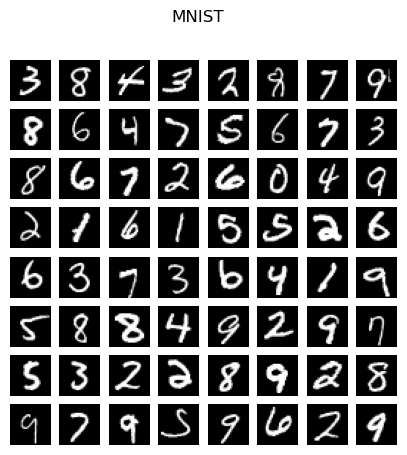

In [2]:
#...Retrieve 100 samples from training sample

data_mnist_reference = load_nist_data(name='MNIST', train=True, binerize=False)
loader_mnist_reference = DataLoader(data_mnist_reference, batch_size=64, shuffle=True)
images_mnist_reference, _ = next(iter(loader_mnist_reference))

plot_images(images_mnist_reference, "MNIST", figsize=(5, 5))

## Perturbed Pepper MNIST 

We first define the reference sample as binarized MNIST (with binarization threshold of 0.5)

We now define the following perturbations of peppered MNIST:
- Pepper MNIST with binarizing thresholds different than 0.5 
- Gaussian noise 
- Gaussian Blurr
- Swirl deformation

We will later compute the FID between these datasets and the reference Pepper MNIST (binerized threshold=0.5) 

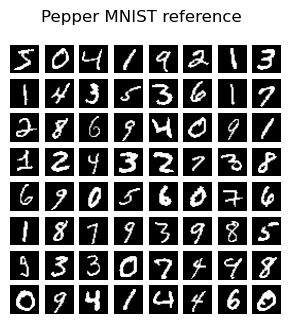

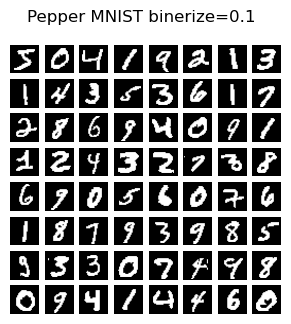

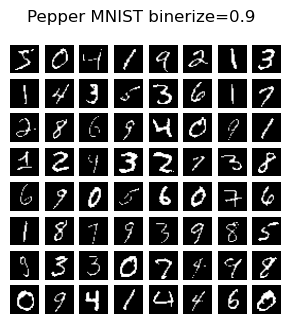

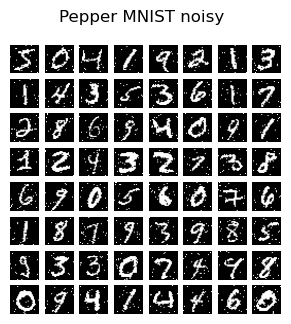

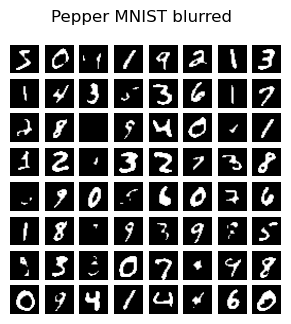

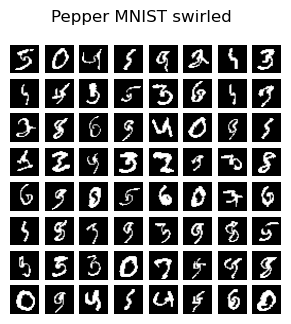

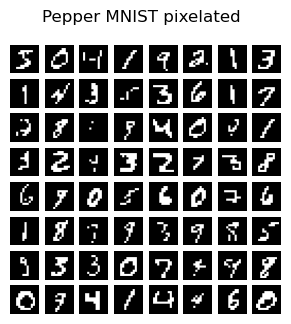

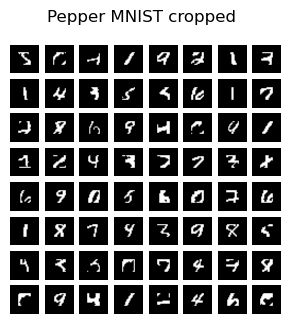

In [7]:
#...Reference dfataset:

data = load_nist_data(name='MNIST', train=True)
dataloader = DataLoader(data, batch_size=64, shuffle=False)
images, _ = next(iter(dataloader))
plot_images(images, "Pepper MNIST reference", figsize=(3.5, 3.5))

#...Distorted datasets:

data = load_nist_data(name='MNIST',  train=True, distortion='binerize', level=0.1)
dataloader = DataLoader(data, batch_size=64, shuffle=False)
images, _ = next(iter(dataloader))
plot_images(images, "Pepper MNIST binerize=0.1", figsize=(3.5, 3.5))

data = load_nist_data(name='MNIST', train=True, distortion='binerize', level=0.9)
dataloader = DataLoader(data, batch_size=64, shuffle=False)
images, _ = next(iter(dataloader))
plot_images(images, "Pepper MNIST binerize=0.9", figsize=(3.5, 3.5))

data = load_nist_data(name='MNIST', train=True, distortion='noise', level=0.25)
dataloader = DataLoader(data, batch_size=64, shuffle=False)
images, _ = next(iter(dataloader))
plot_images(images, "Pepper MNIST noisy", figsize=(3.5, 3.5))

data = load_nist_data(name='MNIST', train=True, distortion='blur', level=1.25)
dataloader = DataLoader(data, batch_size=64, shuffle=False)
images, _ = next(iter(dataloader))
plot_images(images, "Pepper MNIST blurred", figsize=(3.5, 3.5))

data = load_nist_data(name='MNIST', train=True, distortion='swirl', level=3)
dataloader = DataLoader(data, batch_size=64, shuffle=False)
images, _ = next(iter(dataloader))
plot_images(images, "Pepper MNIST swirled", figsize=(3.5, 3.5))

data = load_nist_data(name='MNIST', train=True, distortion='pixelize', level=0.5)
dataloader = DataLoader(data, batch_size=64, shuffle=False)
images, _ = next(iter(dataloader))
plot_images(images, "Pepper MNIST pixelated", figsize=(3.5, 3.5))

data = load_nist_data(name='MNIST', train=True, distortion='crop', level=0.55)
dataloader = DataLoader(data, batch_size=64, shuffle=False)
images, _ = next(iter(dataloader))
plot_images(images, "Pepper MNIST cropped", figsize=(3.5, 3.5))


## Classifier for MNIST
We now train a classifier on the Reference Pepper MNIST data. This will be used later to compute the FID

We test the accuracy of the MNIST Classifier

In [2]:
import torch
from utils import get_model_accuracy
from architectures import LeNet5

model = LeNet5()
model.load_state_dict(torch.load('models/model_MNIST_LeNet5.pth'))
model.eval()

# Load MNIST test dataset

test_data_mnist_ref = load_nist_data(name='MNIST', train=False)
test_dataloader_ref = DataLoader(test_data_mnist_ref, batch_size=1000, shuffle=False)

# Test the model

accuracy = get_model_accuracy(model, 'cpu', test_dataloader_ref)
print('model accuracy = {}%'.format(accuracy))

model accuracy = 98.54%


## FID computations

Below we compute the FID metric between the reference MNIST data and various distortions.
For the classifier we used the LeNet-5 architecture. We show that the FID computed from 
features in the second layer has a better separation power than the featuires extracted from
the first and third layers accross all considered deformation. 

### 1. Binarizing Threshold


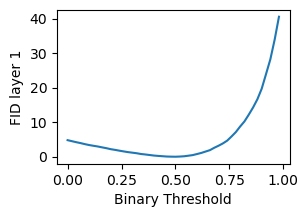

In [23]:
import numpy as np
from fid import distorted_NIST_fid

fid = distorted_NIST_fid(model, name='MNIST', distortion='binerize', values=np.arange(0.0, 1, 0.02), layer='fc1')

fig, ax = plt.subplots(1,1, figsize=(3,2))
plt.plot(fid.keys(), fid.values())
plt.ylabel('FID layer 1')
plt.xlabel('Binary Threshold')
plt.show()

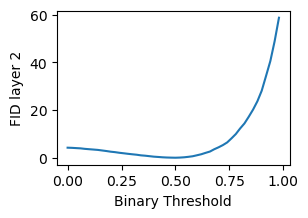

In [24]:
import numpy as np
from fid import distorted_NIST_fid

fid = distorted_NIST_fid(model, name='MNIST', distortion='binerize', values=np.arange(0.0, 1, 0.02), layer='fc2')

fig, ax = plt.subplots(1,1, figsize=(3,2))
plt.plot(fid.keys(), fid.values())
plt.ylabel('FID layer 2')
plt.xlabel('Binary Threshold')
plt.show()

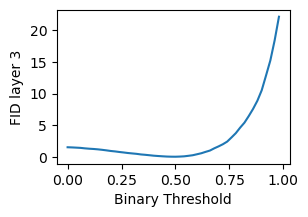

In [25]:
import numpy as np
from fid import distorted_NIST_fid

fid = distorted_NIST_fid(model, name='MNIST', distortion='binerize', values=np.arange(0.0, 1, 0.02), layer='fc3')

fig, ax = plt.subplots(1,1, figsize=(3,2))
plt.plot(fid.keys(), fid.values())
plt.ylabel('FID layer 3')
plt.xlabel('Binary Threshold')
plt.show()

### 2. Gaussian noise

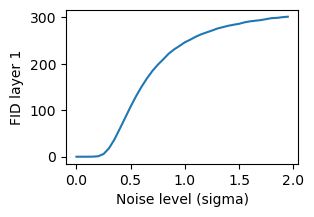

In [26]:
import numpy as np
from fid import distorted_NIST_fid

fid = distorted_NIST_fid(model, name='MNIST', distortion='noise', values=np.arange(0.0, 2, 0.05), layer='fc1')

fig, ax = plt.subplots(1,1, figsize=(3,2))
plt.plot(fid.keys(), fid.values())
plt.ylabel('FID layer 1')
plt.xlabel('Noise level (sigma)')
plt.show()

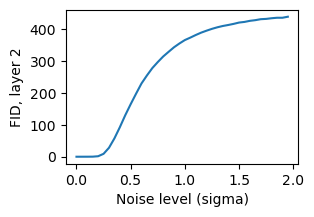

In [27]:
import numpy as np
from fid import distorted_NIST_fid

fid = distorted_NIST_fid(model, name='MNIST', distortion='noise', values=np.arange(0.0, 2, 0.05), layer='fc2')

fig, ax = plt.subplots(1,1, figsize=(3,2))
plt.plot(fid.keys(), fid.values())
plt.ylabel('FID, layer 2')
plt.xlabel('Noise level (sigma)')
plt.show()

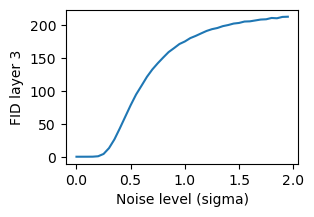

In [28]:
import numpy as np
from fid import distorted_NIST_fid

fid = distorted_NIST_fid(model, name='MNIST', distortion='noise', values=np.arange(0.0, 2, 0.05), layer='fc3')

fig, ax = plt.subplots(1,1, figsize=(3,2))
plt.plot(fid.keys(), fid.values())
plt.ylabel('FID layer 3')
plt.xlabel('Noise level (sigma)')
plt.show()

### 3. Gaussian blur

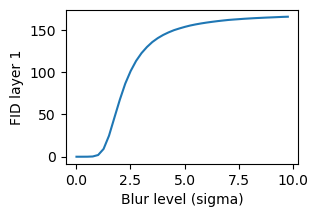

In [10]:
import numpy as np
from fid import distorted_NIST_fid

fid = distorted_NIST_fid(model, name='MNIST', distortion='blur', values=np.arange(0.01, 10, 0.25), layer='fc1')

fig, ax = plt.subplots(1,1, figsize=(3,2))
plt.plot(fid.keys(), fid.values())
plt.ylabel('FID layer 1')
plt.xlabel('Blur level (sigma)')
plt.show()

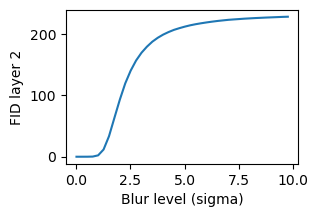

In [11]:
import numpy as np
from fid import distorted_NIST_fid

fid = distorted_NIST_fid(model, name='MNIST', distortion='blur', values=np.arange(0.01, 10, 0.25), layer='fc2')

fig, ax = plt.subplots(1,1, figsize=(3,2))
plt.plot(fid.keys(), fid.values())
plt.ylabel('FID layer 2')
plt.xlabel('Blur level (sigma)')
plt.show()

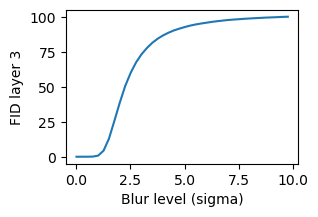

In [12]:
import numpy as np
from fid import distorted_NIST_fid

fid = distorted_NIST_fid(model, name='MNIST', distortion='blur', values=np.arange(0.01, 10, 0.25), layer='fc3')

fig, ax = plt.subplots(1,1, figsize=(3,2))
plt.plot(fid.keys(), fid.values())
plt.ylabel('FID layer 3')
plt.xlabel('Blur level (sigma)')
plt.show()

### 4. Swirl deformation

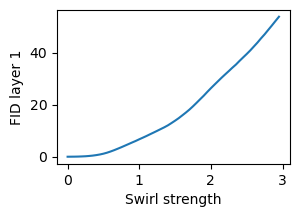

In [20]:
import numpy as np
from fid import distorted_NIST_fid

fid = distorted_NIST_fid(model, name='MNIST', distortion='swirl', values=np.arange(0, 3, 0.05), layer='fc1')

fig, ax = plt.subplots(1,1, figsize=(3,2))
plt.plot(fid.keys(), fid.values())
plt.ylabel('FID layer 1')
plt.xlabel('Swirl strength')
plt.show()

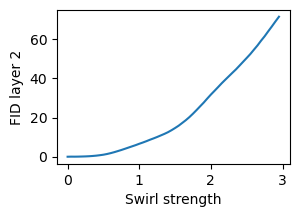

In [21]:
import numpy as np
from fid import distorted_NIST_fid

fid = distorted_NIST_fid(model, name='MNIST', distortion='swirl', values=np.arange(0, 3, 0.05), layer='fc2')

fig, ax = plt.subplots(1,1, figsize=(3,2))
plt.plot(fid.keys(), fid.values())
plt.ylabel('FID layer 2')
plt.xlabel('Swirl strength')
plt.show()

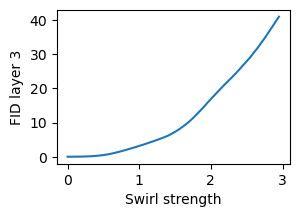

In [22]:
import numpy as np
from fid import distorted_NIST_fid

fid = distorted_NIST_fid(model, name='MNIST', distortion='swirl', values=np.arange(0, 3, 0.05), layer='fc3')

fig, ax = plt.subplots(1,1, figsize=(3,2))
plt.plot(fid.keys(), fid.values())
plt.ylabel('FID layer 3')
plt.xlabel('Swirl strength')
plt.show()

### 5. Pixelization

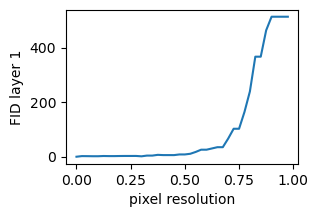

In [14]:
import numpy as np
from fid import distorted_NIST_fid

fid = distorted_NIST_fid(model, name='MNIST', distortion='pixelize', values=np.arange(0, 1, 0.025), layer='fc1')

fig, ax = plt.subplots(1,1, figsize=(3,2))
plt.plot(fid.keys(), fid.values())
plt.ylabel('FID layer 1')
plt.xlabel('pixel resolution')
plt.show()

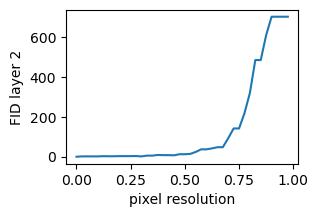

In [15]:
import numpy as np
from fid import distorted_NIST_fid

fid = distorted_NIST_fid(model, name='MNIST', distortion='pixelize', values=np.arange(0, 1, 0.025), layer='fc2')

fig, ax = plt.subplots(1,1, figsize=(3,2))
plt.plot(fid.keys(), fid.values())
plt.ylabel('FID layer 2')
plt.xlabel('pixel resolution')
plt.show()

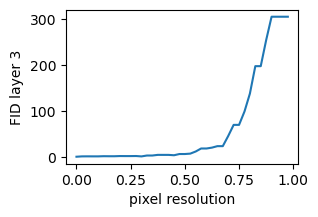

In [16]:
import numpy as np
from fid import distorted_NIST_fid

fid = distorted_NIST_fid(model, name='MNIST', distortion='pixelize', values=np.arange(0, 1, 0.025), layer='fc3')

fig, ax = plt.subplots(1,1, figsize=(3,2))
plt.plot(fid.keys(), fid.values())
plt.ylabel('FID layer 3')
plt.xlabel('pixel resolution')
plt.show()

### 6. Crop image

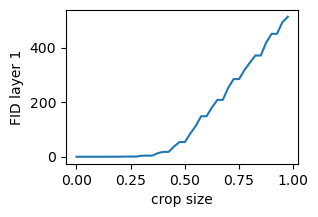

In [17]:
import numpy as np
from fid import distorted_NIST_fid

fid = distorted_NIST_fid(model, name='MNIST', distortion='crop', values=np.arange(0, 1, 0.025), layer='fc1')

fig, ax = plt.subplots(1,1, figsize=(3,2))
plt.plot(fid.keys(), fid.values())
plt.ylabel('FID layer 1')
plt.xlabel('crop size')
plt.show()

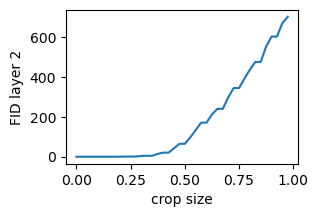

In [18]:
import numpy as np
from fid import distorted_NIST_fid

fid = distorted_NIST_fid(model, name='MNIST', distortion='crop', values=np.arange(0, 1, 0.025), layer='fc2')

fig, ax = plt.subplots(1,1, figsize=(3,2))
plt.plot(fid.keys(), fid.values())
plt.ylabel('FID layer 2')
plt.xlabel('crop size')
plt.show()

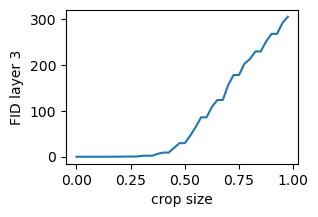

In [19]:
import numpy as np
from fid import distorted_NIST_fid

fid = distorted_NIST_fid(model, name='MNIST', distortion='crop', values=np.arange(0, 1, 0.025), layer='fc3')

fig, ax = plt.subplots(1,1, figsize=(3,2))
plt.plot(fid.keys(), fid.values())
plt.ylabel('FID layer 3')
plt.xlabel('crop size')
plt.show()